In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

try:
    plt.rcParams.update({                      # setup matplotlib to use latex for output
        "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
        "text.usetex": True,                # use LaTeX to write all text
        "font.family": "serif",
        "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
        "font.sans-serif": [],
        "font.monospace": [],
        "figure.figsize": (12,8),
        "axes.labelsize": 12,               # LaTeX default is 10pt font.
        "font.size": 11,
        "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "pgf.preamble": [
            r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
            r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
            ]
        })
except Exception as err:
    traceback.print_exc(err)

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        # this is more like a not so elegant hack to zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

# Training

In [8]:
net = Net()
net.train()

100 0.15004584193229675
200 0.08877906948328018
300 0.0770166665315628
400 0.06782785803079605
500 0.04952007532119751
600 0.028598956763744354
700 0.02279186248779297
800 0.018908139318227768
900 0.017064841464161873
1000 0.017458194866776466
1100 0.010111259296536446
1200 0.0064016226679086685
1300 0.004022929817438126
1400 0.0028393445536494255
1500 0.00198597670532763
1600 0.001551653491333127
1700 0.0012414671946316957
1800 0.0010071115102618933
1900 0.00080698705278337
2000 0.0006300318636931479
2100 0.0005006342544220388
2200 0.00042068626498803496
2300 0.0003605309466365725
2400 0.00029069127049297094
2500 0.0002426604478387162
2600 0.00021822386770509183
2700 0.00020395869796629995
2800 0.00018316561181563884
2900 0.00016744426102377474
3000 0.00015147009980864823
3100 0.00013238551036920398
3200 0.0001155738573288545
3300 0.00010326945630367845
3400 9.573971328791231e-05
3500 8.803901437204331e-05
3600 8.084619912551716e-05
3700 6.71434827381745e-05
3800 6.041110827936791e-05

# Evaluation

In [10]:
# net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [11]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

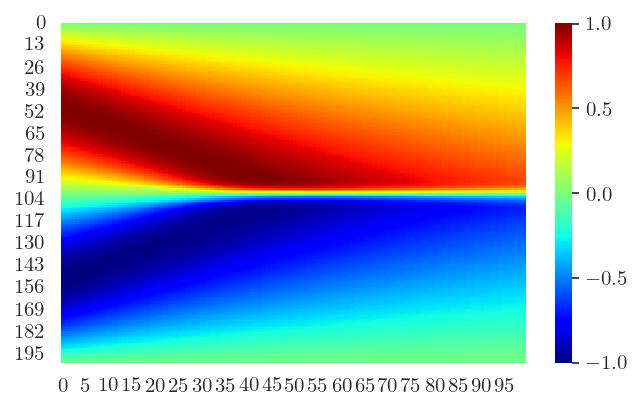

In [18]:
plt.figure(figsize=(5, 3), dpi=150)
sns.heatmap(y_pred, cmap='jet')
plt.show()